Downloanding third-party code for resnet model

In [1]:
!wget https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/d1872999394aa0c234e8d855e3c853eb061f7c06/resnet.py


--2020-03-17 20:13:46--  https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/d1872999394aa0c234e8d855e3c853eb061f7c06/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5001 (4,9K) [text/plain]
Saving to: ‘resnet.py.1’

resnet.py.1         100%[===================>]   4,88K  --.-KB/s    in 0s      

2020-03-17 20:13:47 (47,3 MB/s) - ‘resnet.py.1’ saved [5001/5001]



Downloading/uploading with google drive

In [0]:
# autorize in google dirve
from google.colab import drive
drive.mount('/content/gdrive')

# download model from google drive
def download_model(source_name, saving_name):
  drive.mount('/content/gdrive')
  !cp "gdrive/My Drive/Colab Notebooks/Study/theasis/cifar_models/{source_name}" {saving_name}

# upload model to google drive
def upload_model(source_name, saving_name):
  drive.mount('/content/gdrive')
  !cp {source_name} "gdrive/My Drive/Colab Notebooks/Study/theasis/cifar_models/{saving_name}" 

def upload_logs():
  drive.mount('/content/gdrive')
  !cp -r logs "gdrive/My Drive/Colab Notebooks/Study/theasis/" 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Libs importing

In [4]:
import gc
import os
import datetime

import numpy as np
np.random.seed(42)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils
from torch.utils.data import Subset, ConcatDataset, DataLoader

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import accuracy_score

from resnet import resnet20, BasicBlock, _weights_init, resnet32, resnet56, resnet44, ResNet

def resnet7():return ResNet(BasicBlock, [1, 1, 1])

Declaration of utils

In [5]:
class AverageMeter:
  """Class for computing average values
  """    
  def __init__(self):
    """Init class
    """      
    self.sum_ = 0
    self.count = 0
  
  def update(self, val, count=1):
    """Add new value to track
    
    Arguments:
        val {float} -- new value
    
    Keyword Arguments:
        count {int} -- weigth of val (default: {1})
    """      
    self.sum_ += val
    self.count += count

  def average(self):
    """return average value for given values
    """      
    return self.sum_ / self.count

In [6]:
class TensorBoardLogger:
    """Class for logging into TensorBoard
    """    
    def __init__(self, log_dir, dataset, net, experiment_name):
        """Init logger
        
        Arguments:
            log_dir {string} -- log dir
            dataset {string} -- name of dataset
            experiment_name {string} -- name of experiment
        """        
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir_full = os.path.join(log_dir, dataset, net, experiment_name, current_time)
        self.writer = tf.summary.create_file_writer(log_dir_full)
        self.step_ = 0
        
    def log_scalar(self, tag, value, step=None, description=None):
        """Log scalar
        
        Arguments:
            tag {string} -- name of variable to log
            value {float} -- value of variable
        
        Keyword Arguments:
            step {int} -- current epoch number (default: {None})
            description {string} -- [description] (default: {None})
        """        
        if step is None:
            step = self.step_
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step=step, description=description)
            
    def step(self):
        """Increase epoch number by 1
        """        
        self.step_+=1

    def log_hparams(self, hparams):
        """log hparams
        
        Arguments:
            hparams {dict} -- dict to log
        """      
        with self.writer.as_default():
            hp.hparams(hparams)
        

Dataset declaration

In [7]:
batch_size = 64
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataset_name = "cifar10"

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# augmentation and normaliztion for training
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(32, 4),
     transforms.ToTensor(),
     normalize
     ])

# only normalization for testing
transform_test = transforms.Compose(
    [
     transforms.ToTensor(),
     normalize
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_test)
# split trainvalset into val and train
idx = np.arange(len(trainset))
split = int(len(trainset)*0.15)
np.random.seed(42) # set seed to reproduce given set
np.random.shuffle(idx)
train_idx = idx[split:]
val_idx = idx[:split]

trainset = Subset(trainset, train_idx)
valset = Subset(valset, val_idx)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True, 
                                          )
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True, 
                                          )

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True, )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# check the first index, to check that trainval set splitted correctly
assert val_idx[0]==33553, "invalid val set" 

W0317 20:16:23.380506 139917257680704 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


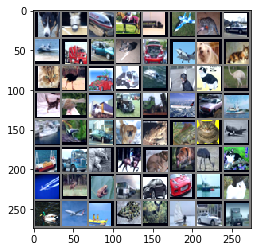

In [10]:
def imshow(img):
    img = img / 4 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

Training functions definition

In [11]:
def accuracy_minibatch(outputs, labels):
  """Compute accuracy for batch
  
  Arguments:
      outputs {list or np.array or torch.Tensor} -- outputs from model (vectors of probabilities)
      labels {list or np.array or torch.Tensor} -- labels (one number for each sample)
  
  Returns:
      float -- accuracy for minibatch
  """  
  if isinstance(outputs, torch.Tensor):
    outputs = outputs.cpu().detach().numpy()
  if isinstance(labels, torch.Tensor):
    labels = labels.cpu().detach().numpy()
  
  predict_= np.argmax(outputs, axis=1)
  true_labels_= labels
  micro_acc_score = accuracy_score(predict_, true_labels_)
  return micro_acc_score

In [12]:
def validate(net, testloader, logger=None, compression_f=None, verbose=True, prename="val"):
  """Function for compute metrics on validation set
  
  Arguments:
      net {torch net} -- model
      testloader {DataLoader} -- set to validation
      
  Keyword Arguments:
      logger {TensorBoardLogger} -- logger (default: {None})
      compression_f {function} -- function to preprocess input (default: {None})
      verbose {bool} -- show metrics (default: {True})
      prename {string} -- prename to name of metric (default: {"val"})
  
  Returns:
      [floats] -- scores for computing metrics
  """  
  # change net to evaluation mode
  net.eval()
  ce_loss_avg = AverageMeter()
  accuracy_score_avg = AverageMeter()
  criterion = nn.CrossEntropyLoss()
  
  # evaluate dataset
  for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    current_batch_size = len(labels)

    if compression_f is not None:
      inputs = compression_f(inputs)
    outputs = net(inputs)
    loss = criterion(outputs, labels).cpu().detach().numpy()
    
    micro_acc_score = accuracy_minibatch(outputs, labels)

    accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)
    ce_loss_avg.update(loss.item()*current_batch_size, current_batch_size)

  accuracy = accuracy_score_avg.average()
  ce_loss = ce_loss_avg.average()
  scores = {
      "%s_accuracy"%prename: accuracy,
      "%s_overall_loss"%prename: ce_loss,
       }
  
  # log scores
  for name, score in scores.items():
    if logger:
      logger.log_scalar(name, score)
    if verbose:
      print(name, score)
  
  if verbose:
    print("__________________")
  # change net to training mode
  net.train()
  return scores

In [0]:
def train_distillation(
    net_teacher, 
    net_student, 
    trainloader, 
    testloader, 
    logger=None,
    compression_f=None, 
    epoches=150,
    verbose=True, 
    return_best=False,
    init_lr=0.1,
    alpha=0.8,
    cos_alpha=0.0,
    l_alpha=0.0,
    p=2,
    temperature=1
    ):
  """Training using knowledge distillation approach
  
  Arguments:
      net_teacher {torch model} -- teacher model
      net_student {torch model} -- student model
      trainloader {DataLoader} -- train set
      testloader {DataLoader} -- test set
  
  Keyword Arguments:
      logger {TensorBoardLogger} -- logger (default: {None})
      compression_f {function} -- function to preprocess input (default: {None})
      epoches {int} -- epochs to train (default: {150})
      verbose {bool} -- show metrics (default: {True})
      return_best {bool} -- return best model (default: {False})
      init_lr {float} -- initial learning rate (default: {0.1})
      alpha {float} -- coefficeint of combining distillation and classical loss (default: {0.8})
      cos_alpha {float} -- coefficeint of combining kl and cosine disimilarity loss (default: {0.0})
      temperature {int} -- temperature (default: {1})
  
  Returns:
      torch model -- best or last model
  """  
  # change net to training mode
  net_student.train()
  net_teacher.eval()
  # use gpu to train
  net_student.cuda()

  criterion_ce = nn.CrossEntropyLoss().cuda()
  criterion_nll = nn.NLLLoss().cuda()
  criterion_bce = nn.BCELoss().cuda() 
  criterion_kl = nn.KLDivLoss(reduction="batchmean").cuda()
  cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)

  optimizer = torch.optim.SGD(
      net_student.parameters(), 
      lr=init_lr,
      momentum=0.9,
      weight_decay=1e-4)
  # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, patience=5, )
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [80, 105, 125, 140])

  validation_scores = []
  os.makedirs("models", exist_ok=True)
  saving_path_template = "models/model_epoch%s.dms"

  for epoch in range(epoches):  # loop over the dataset multiple times
    saving_name = saving_path_template%epoch
    
    loss_avg = AverageMeter()
    accuracy_score_avg = AverageMeter()
    loss_kl_avg = AverageMeter()
    loss_cos_dis_avg = AverageMeter()
    loss_ce_avg = AverageMeter()

    for i, data in enumerate(trainloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        current_batch_size = len(labels)
        inputs, labels = inputs.cuda(), labels.cuda()
        # for supervision transfer
        if compression_f:
          inputs_compressed = compression_f(inputs).detach()
        else:
          inputs_compressed = inputs
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out_student = net_student(inputs_compressed)
        out_teacher = net_teacher(inputs)


        soft_log_probs = F.log_softmax(out_student / temperature, dim=1)

        soft_output = F.softmax(out_student / temperature, dim=1)

        soft_targets = F.softmax(out_teacher / temperature, dim=1)
        
        loss_ce = criterion_ce(out_student, labels)
        # loss_bce = criterion_bce(soft_output, soft_targets.detach())
        kl_loss = criterion_kl(soft_log_probs, soft_targets.detach())
        cos_dis_loss =  (1 - cosine_similarity(out_student - torch.mean(out_student, dim=1, keepdim=True), out_teacher.detach() - torch.mean(out_teacher.detach(), dim=1, keepdim=True))).mean()
        
        
        l_loss = (torch.abs(out_student - out_teacher)**p).mean()**(1/p)

        loss = (1 - cos_alpha - l_alpha) * kl_loss + cos_alpha * cos_dis_loss + l_alpha * l_loss
        loss.backward()
        optimizer.step()
      
        micro_acc_score = accuracy_minibatch(out_student, labels)

        loss_avg.update(loss.item()*current_batch_size, current_batch_size)
        accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)
        loss_kl_avg.update(kl_loss.item()*current_batch_size, current_batch_size)
        loss_cos_dis_avg.update(cos_dis_loss.item()*current_batch_size, current_batch_size)
        loss_ce_avg.update(loss_ce.item()*current_batch_size, current_batch_size)

    if verbose:
        print(saving_name)
        print('overall loss {:.3}'.format(loss_avg.average()))
        print('loss kl {:.3}'.format(loss_kl_avg.average()))
        print('loss cos dis {:.3}'.format(loss_cos_dis_avg.average()))
        print('loss ce {:.3}'.format(loss_ce_avg.average()))
        print('current lr {:.3e}'.format(optimizer.param_groups[0]['lr']))
        print("__________________")
    # clear memory 
    gc.collect()
    torch.cuda.empty_cache()  
    
    # save scores to take best model in the future
    validation_score = validate(net_student, valloader, 
                                logger=logger, 
                                verbose=verbose, 
                                compression_f=compression_f)
    accuracy = validation_score['val_accuracy']
    validation_scores.append(accuracy)
    # save model
    torch.save(net_student.state_dict(), saving_name)

    if logger:
        logger.log_scalar("overall_loss", loss_avg.average())
        logger.log_scalar("accuracy", accuracy_score_avg.average())
        logger.log_scalar("kl_loss", loss_kl_avg.average())
        logger.log_scalar("cos_dis_loss", loss_cos_dis_avg.average())
        logger.log_scalar("ce_loss", loss_ce_avg.average())
        logger.step()
    # scheduler.step(loss_avg.average())
    scheduler.step()
    
  best_epoch = np.argmax(validation_scores)
  if return_best:
    choosen_epoch = best_epoch
  else:
    choosen_epoch = epoch
  if verbose:
    print("choosen epoch:", choosen_epoch, ", score:", validation_scores[choosen_epoch])
    print("best epoch:", best_epoch, ", score:", validation_scores[best_epoch])
  model_name = saving_path_template%choosen_epoch
  net_student.load_state_dict(torch.load(model_name))
  return net_student

In [0]:
for net_teacher, teacher_name, alpha, corr_alpha, l_alpha, exp_prename in [
    (resnet20(), "resnet20_classic.pt", 1.0, 0.0, 0.0, "kl"),
    (resnet20(), "resnet20_classic.pt", 1.0, 0.0, 1.0, "rmse"),
    (resnet20(), "resnet20_classic.pt", 1.0, 0.0, 0.5, "rmse_kl"), 
    (resnet20(), "resnet20_classic.pt", 1.0, 1.0, 0.0, "corr"), 

    (resnet32(), "resnet32_classic.pt", 1.0, 0.0, 0.0, "kl"),
    (resnet32(), "resnet32_classic.pt", 1.0, 0.0, 1.0, "rmse"),
    (resnet32(), "resnet32_classic.pt", 1.0, 0.0, 0.5, "rmse_kl"), 
    (resnet32(), "resnet32_classic.pt", 1.0, 1.0, 0.0, "corr"), 

    (resnet44(), "resnet44_classic.pt", 1.0, 0.0, 0.0, "kl"),
    (resnet44(), "resnet44_classic.pt", 1.0, 0.0, 1.0, "rmse"),
    (resnet44(), "resnet44_classic.pt", 1.0, 0.0, 0.5, "rmse_kl"), 
    (resnet44(), "resnet44_classic.pt", 1.0, 1.0, 0.0, "corr"), 
                  ]:
  download_model(teacher_name, teacher_name)
  state_dict = torch.load(teacher_name)
  net_teacher.cuda().load_state_dict(state_dict)
  net_student = resnet7().cuda()

  alpha = 1.0
  
  experiment_name = "distillation_"+teacher_name[:-10]+exp_prename+".pt"
  save_name = "resnet7_"+experiment_name
  logger = TensorBoardLogger("logs", dataset_name,  "resnet7", experiment_name)
  net_student = train_distillation(net_teacher, net_student, 
                                   trainloader, valloader, 
                                   logger=logger, return_best=True,
                                   alpha=alpha, 
                                   cos_alpha=corr_alpha, 
                                   l_alpha=l_alpha,
                                   epoches=150)

  print("-----------------")
  print("*****************")
  print(experiment_name)
  score_test = validate(net_student, testloader, prename='test')
  score_val = validate(net_student, valloader, prename='val')
  validate(net_student, trainloader, prename='train')

  print("----------------")
  print("teacher")
  score_teacher_test = validate(net_teacher, testloader, prename='test')
  score_teacher_val = validate(net_teacher, valloader, prename='val')
  validate(net_teacher, trainloader, prename='train')
  print("----------------")

  hparams = {"experiment_name":experiment_name, "teacher":teacher_name, "dataset":dataset_name, "correllation":corr_alpha, "alpha":alpha, "l_alpha":l_alpha}
  for key, value in score_val.items():
    hparams["student/"+key] = value
  for key, value in score_test.items():
    hparams["student/"+key] = value
  
  for key, value in score_teacher_test.items():
    hparams["teacher/"+key] = value
  for key, value in score_teacher_val.items():
    hparams["teacher/"+key] = value

  logger.log_hparams(hparams) 

  torch.save(net_student.state_dict(), save_name)
  upload_model(save_name, save_name)
  upload_logs()

models/model_epoch117.dms
overall loss 0.25
loss kl 0.25
loss cos dis 0.188
loss ce 0.254
current lr 1.000e-03
__________________
val_accuracy 0.8785333333333334
val_overall_loss 0.3697348663171132
__________________
models/model_epoch118.dms
overall loss 0.247
loss kl 0.247
loss cos dis 0.187
loss ce 0.251
current lr 1.000e-03
__________________
val_accuracy 0.8789333333333333
val_overall_loss 0.3731237466255824
__________________
models/model_epoch119.dms
overall loss 0.25
loss kl 0.25
loss cos dis 0.187
loss ce 0.254
current lr 1.000e-03
__________________
val_accuracy 0.8796
val_overall_loss 0.364107825756073
__________________
models/model_epoch120.dms
overall loss 0.25
loss kl 0.25
loss cos dis 0.187
loss ce 0.254
current lr 1.000e-03
__________________
val_accuracy 0.8770666666666667
val_overall_loss 0.3711899522145589
__________________
models/model_epoch121.dms
overall loss 0.248
loss kl 0.248
loss cos dis 0.187
loss ce 0.253
current lr 1.000e-03
__________________
val_accurac